In [1]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as colors
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import numpy as np
from prettytable import PrettyTable
from PIL import Image
import io

def plot_histograms(super_histograms,scaling=1000,upper_cutoff=None):

    max_num = 0
    min_num = 1000000000000000000000000000000
    steps = []
    for histograms in super_histograms:
        local_steps = []
        for hist in histograms:
            local_steps.append(hist.step)
        if len(local_steps) > len(steps):
            steps = local_steps
    
    for histograms in super_histograms:
        for hist in histograms:
            num = hist.histogram_value.num
            if num > max_num:
                max_num = num
            if num < min_num:
                min_num = num

    fig,axs = plt.subplots(len(steps),len(super_histograms))

    if len(super_histograms) == 1:
        axs = axs[:,None]

    #cmap = plt.cm.viridis 
    #cmap = colors.LinearSegmentedColormap.from_list("viridis_cut",cmap(np.linspace(0.05,0.95,100)))
    cmap = sns.color_palette("blend:green,yellow,orange,red,firebrick",as_cmap=True)
    norm = Normalize(vmin=min_num, vmax=max_num)

    def _plot_histograms(histograms,axs):
        for i,hist in enumerate(histograms):
            step = hist.step
            num = hist.histogram_value.num
            bucket_limit = hist.histogram_value.bucket_limit
            count = hist.histogram_value.bucket

            if upper_cutoff:
                bucket_limit = [bucket_limit[i] for i in range(len(bucket_limit)) if bucket_limit[i]<upper_cutoff]
                count = [count[i] for i in range(len(bucket_limit)) if bucket_limit[i]<upper_cutoff]

            bucket_center = [hist.histogram_value.bucket_limit[0],*[(bucket_limit[i]+bucket_limit[i+1])/2 for i in range(len(bucket_limit)-1)]]
            count_approx = [int(c/scaling) for c in count]
            samples = [e for bc,ca in zip(bucket_center,count_approx) for e in [bc]*ca]
            samples = np.array(samples)

            df = pd.DataFrame({'value': samples,'step': step})
            ax = axs[i]
            
            sns.kdeplot(df,ax=ax,fill=True,warn_singular=False)

            # set color
            ax.collections[0].set_facecolor(cmap(norm(num))) 
            ax.collections[0].set_edgecolor("black") 
            ax.get_legend().remove()
            
        for i,ax in enumerate(axs):
            # make axis transparent
            ax.patch.set_alpha(0) 

            ax.set_yticks([])
            ax.set_yticklabels([])
            ax.set_ylabel("")

            # remove xtick/labels for all but bottom axis
            if i < axs.shape[0]-1:
                ax.set_xticks([])
                ax.set_xticklabels([])

            if i < axs.shape[0]-1:
                ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)


    for i,histograms in enumerate(super_histograms):
        _plot_histograms(histograms,axs[:,i])

    # Make the axes overlap
    #### TAKEN FROM: https://github.com/leotac/joypy ####
    h_pad = 5 + (- 5*(1 + 1))
    fig.tight_layout(h_pad=h_pad)
    #####################################################################################

    # Add the y axis on the far left based on axes positions
    yax = fig.add_axes([axs[-1,0].get_position().x0-0.02, axs[-1,0].get_position().y0, 0.02, axs[0,0].get_position().y0-axs[-1,0].get_position().y0]) 
    yax.yaxis.set_ticks_position('left')
    yax.xaxis.set_visible(False)
    yax.spines['top'].set_visible(False)
    yax.spines['right'].set_visible(False)
    yax.spines['bottom'].set_visible(False)
    yticks = []
    ylabels = []
    for ax,step in zip(axs[:,0],steps):
        yticks.append((ax.get_position().y0-axs[-1,0].get_position().y0)/(axs[0,0].get_position().y0-axs[-1,0].get_position().y0))
        ylabels.append(step)
    yax.set_yticks(yticks)
    yax.set_yticklabels(ylabels)
    
    # Make colormap legend
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([]) 
    color_legend_ax = fig.add_axes([1,axs[-1,0].get_position().y0+axs[-1,0].get_position().y0, 0.02, axs[0,0].get_position().y0-2*axs[-1,0].get_position().y0])
    fig.colorbar(sm, cax=color_legend_ax)
    
    return fig,axs

def mean_fn(l):
    return sum(l)/len(l)

def info_table(event_accs):
    data_table = PrettyTable(['Exp', 'Num Gaussians', 'Max Mem used (GB)', 'avg itertime (s)','total time (m)','Min total train loss','Min test l1_loss','Max test psnr', 'Max test ssim', 'Min test lpips'])

    for name,event_acc in event_accs.items():
        data_table.add_row([name,
                            event_acc.Scalars("total_points")[-1].value,
                            round(max([event.value for event in event_acc.Scalars("mem")])/1024**3,2),
                            round(sum([event.value for event in event_acc.Scalars("iter_time")])/36000,2),
                            round((event_acc.Scalars("total_points")[-1].wall_time - event_acc.Scalars("total_points")[0].wall_time)/60,2),
                            round(min([event.value for event in event_acc.Scalars('train_loss_patches/total_loss')]),4),
                            round(min([event.value for event in event_acc.Scalars("test/loss_viewpoint - l1_loss")]),4),
                            round(max([event.value for event in event_acc.Scalars("test/loss_viewpoint - psnr")]),4),
                            round(max([event.value for event in event_acc.Scalars("test/loss_viewpoint - ssim")]),4),
                        round(min([event.value for event in event_acc.Scalars("test/loss_viewpoint - lpips")]),4)])
    
    return data_table

def get_zoom_fn(x,y,s):
    return lambda img : img.crop((x-img.width/s,y-img.height/s,x+img.width/s,y+img.height/s)) 

def plot_images(event_accs, idx, img, zoom_fns = [None]):
    fig,axs = plt.subplots(len(zoom_fns),len(list(event_accs.values())))
    if len(zoom_fns) == 1:
        axs = axs[None,:]
    for x,zoom_fn in enumerate(zoom_fns):
        for y,(name,event_acc) in enumerate(event_accs.items()):    
            ax = axs[x,y]
            if zoom_fn:
                ax.imshow(zoom_fn(Image.open(io.BytesIO(event_acc.Images(img)[idx].encoded_image_string))))
            else:
                ax.imshow(Image.open(io.BytesIO(event_acc.Images(img)[idx].encoded_image_string)))

            ax.set_xticks([])
            ax.set_xticklabels([])
            ax.set_yticks([])
            ax.set_yticklabels([])
    return fig,axs

def subdict(d,*ks):
    return {k : d[k] for k in ks}


In [134]:
event_accs_fn = lambda names,paths : {name : EventAccumulator(path,size_guidance={"images" : 0,'histograms': 0,}) for name,path in zip(names,paths)}


event_acc_bonsai = event_accs_fn(["orig","orig + depth_reg","orig + opacity_reg","mini","compact3d","mini + compact3d","mini + opacity_reg","mini w less depth","mini w less depth + opacity_reg"],
                            [f"./output/{sp}/bonsai" for sp in ["orig","orig_depth_reg","orig_opacity","mini","compact3d","mini_compact3d","mini_opacity","mini_lessdepth","mini_lessdepth_opacity"]])

event_acc_bicycle = event_accs_fn(["orig","orig + depth_reg","orig + opacity_reg","mini","compact3d","mini + compact3d","mini + opacity_reg","mini w less depth","mini w less depth + opacity_reg","mini + opacity_reg (no_prune)"],
                            [f"./output/{sp}/bicycle" for sp in ["orig","orig_depth_reg","orig_opacity","mini","compact3d","mini_compact3d","mini_opacity","mini_lessdepth","mini_lessdepth_opacity","mini_opacity_noprune"]])


In [135]:
for event_acc in event_acc_bicycle.values():
    event_acc.Reload()

In [136]:
print(info_table(event_acc_bicycle))

+---------------------------------+---------------+-------------------+------------------+----------------+----------------------+------------------+---------------+---------------+----------------+
|               Exp               | Num Gaussians | Max Mem used (GB) | avg itertime (s) | total time (m) | Min total train loss | Min test l1_loss | Max test psnr | Max test ssim | Min test lpips |
+---------------------------------+---------------+-------------------+------------------+----------------+----------------------+------------------+---------------+---------------+----------------+
|               orig              |   4746115.0   |        9.55       |      15.73       |     45.03      |        0.0335        |      0.0387      |    25.1605    |     0.7484    |     0.2426     |
|         orig + depth_reg        |   4739983.0   |        9.55       |      15.61       |     44.75      |        0.0337        |      0.0386      |    25.1605    |     0.7481    |     0.2426     |
|    

In [2]:
import torch
from scene import Scene
import os
from tqdm import tqdm
from os import makedirs
from gaussian_renderer import render
import torchvision
from utils.general_utils import safe_state
from argparse import ArgumentParser,Namespace
from arguments import ModelParams, PipelineParams
from gaussian_renderer import GaussianModel


#### Taken from arguments/__init__.py
def get_combined_args(parser : ArgumentParser,ptm,ptds):
    cmdlne_string = ["-m",ptm,"-s",ptds]
    cfgfile_string = "Namespace()"
    args_cmdline = parser.parse_args(cmdlne_string)

    try:
        cfgfilepath = os.path.join(args_cmdline.model_path, "cfg_args")
        print("Looking for config file in", cfgfilepath)
        with open(cfgfilepath) as cfg_file:
            print("Config file found: {}".format(cfgfilepath))
            cfgfile_string = cfg_file.read()
    except TypeError:
        print("Config file not found at")
        pass
    args_cfgfile = eval(cfgfile_string)

    merged_dict = vars(args_cfgfile).copy()
    for k,v in vars(args_cmdline).items():
        if v != None:
            merged_dict[k] = v
    return Namespace(**merged_dict)

path_to_model = "./output/orig/bicycle"
path_to_ds = "./360_v2/bicycle"
iteration=30000
load_quant = False
SPARSE_ADAM_AVAILABLE = False

parser = ArgumentParser()
dataset = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
args = get_combined_args(parser,path_to_model,path_to_ds)

dataset = dataset.extract(args)
pipeline = pipeline.extract(args)

gaussians = GaussianModel(dataset.sh_degree)
scene = Scene(dataset, gaussians, load_iteration=iteration, shuffle=False, load_quant=load_quant)

bg_color = [1,1,1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
views = scene.getTestCameras()


/home/miri/miniconda3/envs/gaussian_splatting/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Looking for config file in ./output/orig/bicycle/cfg_args
Config file found: ./output/orig/bicycle/cfg_args
Loading trained model at iteration 30000
------------LLFF HOLD-------------
Reading camera 194/194
Loading Training Cameras
[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.
 If this is not desired, please explicitly specify '--resolution/-r' as 1
Loading Test Cameras
load quant: False
quant params: []


load quant: False
quant params: []


Rendering progress:   4%|▍         | 1/25 [00:00<00:00, 36.38it/s]


load quant: False
quant params: []


Rendering progress:   4%|▍         | 1/25 [00:00<00:00, 37.83it/s]


load quant: False
quant params: []


Rendering progress:   4%|▍         | 1/25 [00:00<00:00, 54.99it/s]


load quant: True
quant params: ['sh', 'dc', 'rot', 'scale']


Rendering progress:   4%|▍         | 1/25 [00:00<00:00, 53.83it/s]


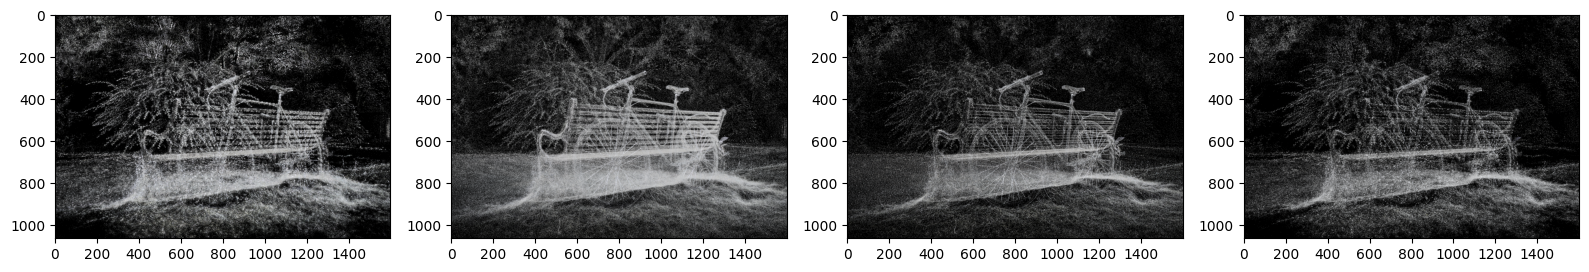

In [14]:
import copy
from PIL import Image

paths = ["./output/orig/bicycle","./output/mini/bicycle","./output/mini_opacity/bicycle","./output/compact3d/bicycle"]

fig,axs = plt.subplots(1,len(paths))
for i,p in enumerate(paths):
    scene.gaussians.load_ply(os.path.join(p,"point_cloud","iteration_" + str(30000),"point_cloud.ply"), "compact3d" in p, args.train_test_exp)
    for idx, view in enumerate(tqdm(views, desc="Rendering progress")):
        if not view.image_name == "_DSC8687.JPG":
            continue
        mask = lambda l : l[gaussians.get_opacity[:,0]>0.0]
        new_gaussians = copy.deepcopy(gaussians)
        new_gaussians._xyz = mask(gaussians._xyz)
        new_gaussians._rotation = mask(gaussians._rotation)
        new_gaussians._opacity = mask(-torch.ones_like(gaussians._opacity)*1)
        #scaling = mask(torch.linalg.norm(scene.gaussians.get_scaling,ord=2,dim=-1))
        #scaling = torch.where(scaling<0.03,0,0.3)
        #new_gaussians._opacity = gaussians.inverse_opacity_activation(scaling)
        new_gaussians._scaling = mask(-torch.ones_like(gaussians._scaling)*10)
        new_gaussians._features_dc = mask(torch.ones_like(gaussians._features_dc))
        #new_gaussians._features_dc = mask(torch.linalg.norm(scene.gaussians.get_scaling,ord=2,dim=-1))[:,None,None].repeat(1,1,3)*10
        new_gaussians._features_rest = mask(gaussians._features_rest)
        out = render(view, new_gaussians, pipeline, torch.tensor([0, 0, 0], dtype=torch.float32, device="cuda"), use_trained_exp=dataset.train_test_exp, separate_sh=SPARSE_ADAM_AVAILABLE)
        axs[i].imshow(out["render"].permute(1,2,0).cpu().detach())
        #gt = view.original_image[0:3, :, :]
        #axs[1][i].imshow(get_zoom_fn(500,200,25)(Image.fromarray(np.uint8(255*out["render"].detach().permute(1,2,0).cpu().numpy()))))
        #axs[2][i].imshow(get_zoom_fn(1120,670,35)(Image.fromarray(np.uint8(255*out["render"].detach().permute(1,2,0).cpu().numpy()))))
        break
    fig.set_size_inches(16,12)

fig.tight_layout()

In [ ]:
fig,axs = plt.subplots(1,2)

for idx, view in enumerate(tqdm(views, desc="Rendering progress")):
    out = render(view, gaussians, pipeline, background, use_trained_exp=dataset.train_test_exp, separate_sh=SPARSE_ADAM_AVAILABLE)
    print(out["viewspace_points"].shape)
    with torch.no_grad():
        xyz_ = torch.concat([gaussians.get_xyz, torch.ones((gaussians.get_xyz.shape[0],1)).cuda()], axis=1) @ view.full_proj_transform.T
        xyz_ = xyz_/xyz_[:,3][:,None]
        perm = torch.randperm(xyz_.shape[0])
        size = 1000000
        x = xyz_[perm,0].cpu()[:size]
        y = xyz_[perm,1].cpu()[:size]
        value = gaussians.get_opacity[perm,0].cpu()[:size]
        #value = torch.linalg.norm(scene.gaussians.get_scaling,ord=2,dim=-1)[:].cpu()

        x_corr = x[(x > -1) & (x<1) & (y>-1) & (y<1)]
        y_corr = y[(x > -1) & (x<1) & (y>-1) & (y<1)]
        #value_corr = value[(x > -1) & (x<1) & (y>-1) & (y<1)]

        x_corr = view.image_width*(x_corr+1)/2
        y_corr = view.image_height*(y_corr+1)/2

        #axs[0].tricontour(x_corr,y_corr,value_corr)
        #axs[0].scatter(x_corr,y_corr, c=value_corr,s=0.1)

    gt = view.original_image[0:3, :, :]
    axs[0].imshow(gt.permute(1,2,0).cpu().numpy())

    gt = view.original_image[0:3, :, :]
    axs[1].imshow(gt.permute(1,2,0).cpu().numpy())

    cmap = plt.cm.viridis 
    cmap = colors.LinearSegmentedColormap.from_list("viridis_opaque",np.asarray([1,1,1,0.5])*cmap(np.linspace(0,1,100)))
    sns.kdeplot(
        x=x_corr,
        y=y_corr,
        cmap=cmap,
        fill=True,
        bw_adjust=0.5,
        ax=axs[1]
    )
    #axs[0].axis('equal')

    break

fig.set_size_inches(12,6)


Rendering progress:   0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([4514344, 3])


In [11]:
fig,axs = plot_images(subdict(event_acc_bicycle,"orig","mini","compact3d","mini + opacity_reg"),-1,'test_view__DSC8687.JPG/render',[None,get_zoom_fn(1120,670,35),get_zoom_fn(1300,300,10)])
fig.set_size_inches(16,12)
fig.tight_layout(h_pad=-12)

NameError: name 'event_acc_bicycle' is not defined

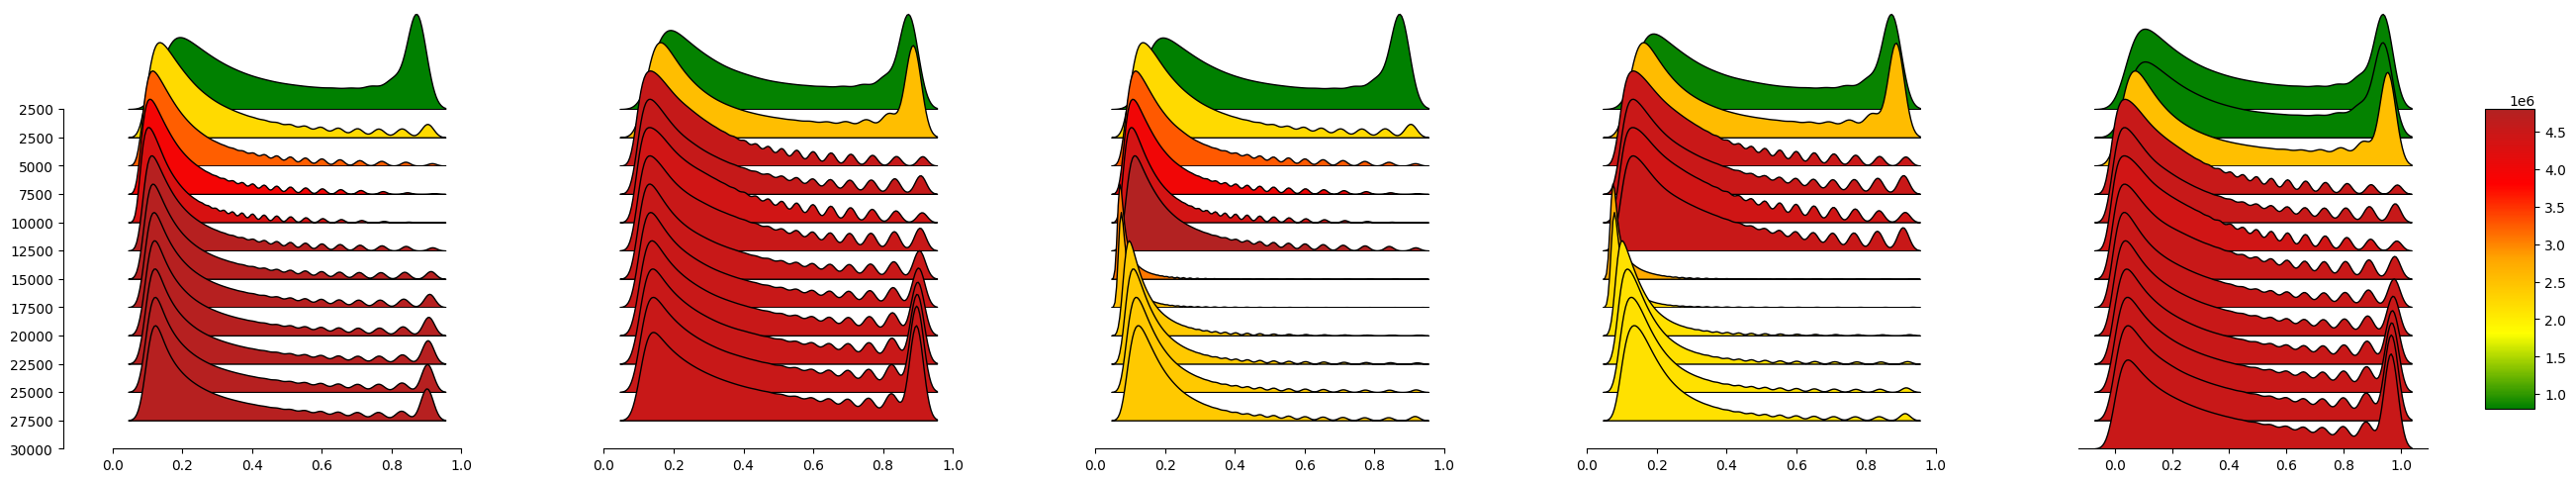

In [138]:
fig,axs = plot_histograms([event_acc.Histograms("scene/opacity_histogram") for event_acc in subdict(event_acc_bicycle,"orig","mini","compact3d","mini + opacity_reg","mini + opacity_reg (no_prune)").values()],scaling=10)
fig.set_size_inches(axs.shape[1]*5,5)

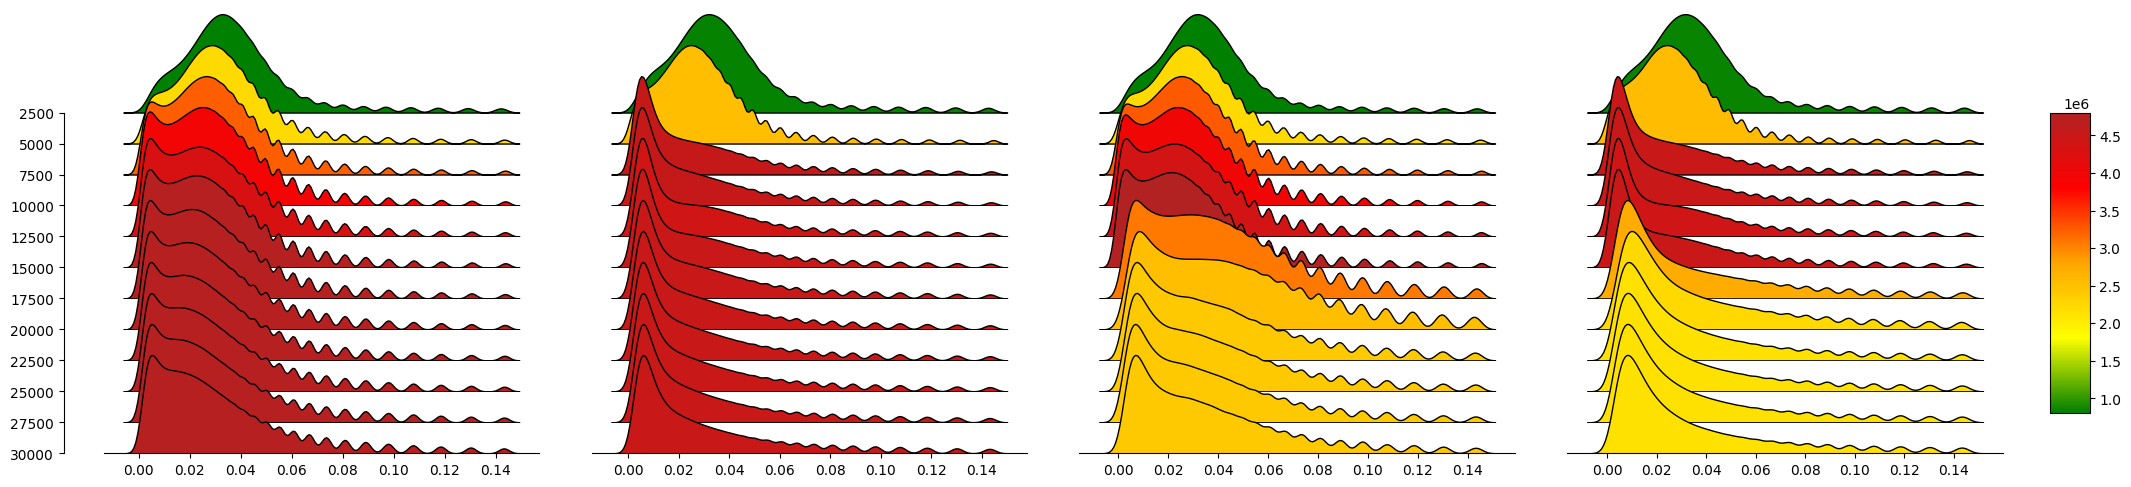

In [220]:
fig,axs = plot_histograms([event_acc.Histograms("scene/size_histogram") for event_acc in subdict(event_acc_bicycle,"orig","mini","compact3d","mini + opacity_reg").values()],scaling=10,upper_cutoff=0.15)
fig.set_size_inches(axs.shape[1]*5,5)